# BP simulation notebook

In [1]:
import datetime as dt
from slot import *
from car import *
from crossvalidation import *
from utils import *
from simulation import *
from main import *
from optimize import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.dates as mdates
import glob

## Charging station setup from Skoda Auto

In [2]:
default_cpct = [14, 1, 2, 3, 1, 1, 6, 1, 2 ,3, 3, 1, 1, 2, 2, 40, 24, 27] #capacity
#default_cpct = [i * 2 for i in default_cpct]
traffic = load_traffic("input/3_traffic_export_may.csv") #traffic exported from SQL database
slots = create_slots(default_cpct)
sim1 = Simulation(traffic, slots, "Skoda")
sim1.simulate()


Total charging time: 219 days, 6:36:40, distributed electricity: 89464.38888888889 kWh, charged cars: 5255/11678 = 44.99914368898784%, name: Skoda


In [3]:
sum(default_cpct)

134

Below is history log of one of charging slots.

In [4]:
s1 = sim1.slots[1]
s1.log.head(10)


,car_id,park_id,arrival,departure,satisfied
0,568202,1,2019-05-01 06:57:03,2019-05-01 15:21:50,True
1,577352,1,2019-05-01 19:57:32,2019-05-01 21:02:36,True
2,577352,1,2019-05-01 21:10:10,2019-05-01 22:45:19,True
3,550419,1,2019-05-02 00:10:56,2019-05-02 00:38:18,True
4,572142,1,2019-05-02 03:55:05,2019-05-02 06:38:36,True
5,559851,1,2019-05-02 04:09:11,2019-05-02 04:22:50,False
6,574588,1,2019-05-02 04:27:31,2019-05-02 06:15:30,False
7,591704,1,2019-05-02 05:12:27,2019-05-02 08:29:15,False
8,567725,1,2019-05-02 05:12:27,2019-05-02 08:29:15,False
9,580266,1,2019-05-02 06:17:30,2019-05-02 06:28:00,False


In [5]:
print((sim1.total_ch_time.seconds/3600 + sim1.total_ch_time.days*24) * 17 )
print(sim1.total_kWh) 

89464.38888888889
89464.38888888889


In [6]:
#Sum up results of simulation
slots = sim1.slots
id = []
total = []
satisfied = []
for slot in slots:
    id.append(slot.id)
    tmp_log = slot.log
    total.append(tmp_log['car_id'].count())
    satisfied.append(tmp_log.loc[tmp_log['satisfied'] == True]['car_id'].count())


In [7]:
data = {'slot_id':id,
        'satisfied':satisfied,
        'total':total}

usage = pd.DataFrame(data)
usage['satisfied_perc'] = (usage['satisfied']/usage['total'])*100
usage['total_perc'] = (usage['total']/sum(usage['total']))
usage['weighted_setup'] = (sum(default_cpct)*usage['total_perc']).round()
usage['total_perc'] = usage['total_perc']*100

In [8]:
#Exporting weighted setup for second simulation
weighted_setup = usage['weighted_setup'].astype(int).to_list()
usage.head(18)

,slot_id,satisfied,total,satisfied_perc,total_perc,weighted_setup
0,0,464,464,100.000000,3.973283,5.0
1,1,335,1328,25.225904,11.371810,15.0
2,2,249,897,27.759197,7.681110,10.0
3,3,282,336,83.928571,2.877205,4.0
4,4,177,839,21.096544,7.184449,10.0
5,5,340,1537,22.121015,13.161500,18.0
6,6,442,473,93.446089,4.050351,5.0
7,7,122,372,32.795699,3.185477,4.0
8,8,718,1906,37.670514,16.321288,22.0
9,9,652,819,79.609280,7.013187,9.0


In [9]:
usage['satisfied_perc'].mean()
sum(weighted_setup)

133

## Simulation with charging stations distributed based on weights

In [10]:
slots2 = create_slots(weighted_setup)
sim2 = Simulation(traffic, slots2, "weighted")
sim2.simulate()

Total charging time: 415 days, 7:03:20, distributed electricity: 169439.9444444445 kWh, charged cars: 10949/11678 = 93.7574927213564%, name: weighted


In [11]:
slots2 = sim2.slots
id2 = []
total2 = []
satisfied2 = []
for slot in slots2:
    id2.append(slot.id)
    tmp_log = slot.log
    total2.append(tmp_log['car_id'].count())
    satisfied2.append(tmp_log.loc[tmp_log['satisfied'] == True]['car_id'].count())

In [12]:
data2 = {'slot_id':id,
        'satisfied':satisfied2,
        'total':total2}

usage2 = pd.DataFrame(data2)
usage2['satisfied_perc'] = (usage2['satisfied']/usage2['total'])*100
usage2['total_perc'] = (usage2['total']/sum(usage2['total']))
usage2['weighted_setup'] = (sum(weighted_setup)*usage2['total_perc']).round()
usage2['total_perc'] = usage2['total_perc']*100

In [13]:
usage2.head(18)


,slot_id,satisfied,total,satisfied_perc,total_perc,weighted_setup
0,0,376,464,81.034483,3.973283,5.0
1,1,1325,1328,99.774096,11.371810,15.0
2,2,829,897,92.419175,7.681110,10.0
3,3,313,336,93.154762,2.877205,4.0
4,4,803,839,95.709178,7.184449,10.0
5,5,1537,1537,100.000000,13.161500,18.0
6,6,414,473,87.526427,4.050351,5.0
7,7,307,372,82.526882,3.185477,4.0
8,8,1905,1906,99.947534,16.321288,22.0
9,9,816,819,99.633700,7.013187,9.0


In [14]:
usage2['satisfied_perc'].mean()

86.80000444488678

## Simulation with equally distributed charging stations

In [15]:
equal_setup = [8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
#equal_setup = [i * 2 for i in equal_setup]

slots3 = create_slots(equal_setup)
sim3 = Simulation(traffic, slots3, "equal")
sim3.simulate()

Total charging time: 410 days, 15:39:40, distributed electricity: 167546.23888888885 kWh, charged cars: 10487/11678 = 89.80133584517897%, name: equal


In [16]:
slots3 = sim3.slots
total3 = []
id3 = []
satisfied3 = []
for slot in slots3:
    id3.append(slot.id)
    tmp_log = slot.log
    total3.append(tmp_log['car_id'].count())
    satisfied3.append(tmp_log.loc[tmp_log['satisfied'] == True]['car_id'].count())

In [17]:
data3 = {'slot_id':id3,
        'satisfied':satisfied3,
        'total':total3}

usage3 = pd.DataFrame(data3)
usage3['satisfied_perc'] = (usage3['satisfied']/usage3['total'])*100
usage3['total_perc'] = (usage3['total']/sum(usage3['total']))
usage3['weighted_setup'] = (sum(equal_setup)*usage3['total_perc']).round()
usage3['total_perc'] = usage3['total_perc']*100

In [18]:
usage3.head(18)

,slot_id,satisfied,total,satisfied_perc,total_perc,weighted_setup
0,0,436,464,93.965517,3.973283,5.0
1,1,1213,1328,91.340361,11.371810,15.0
2,2,741,897,82.608696,7.681110,10.0
3,3,336,336,100.000000,2.877205,4.0
4,4,757,839,90.226460,7.184449,10.0
5,5,1344,1537,87.443071,13.161500,18.0
6,6,471,473,99.577167,4.050351,5.0
7,7,370,372,99.462366,3.185477,4.0
8,8,1478,1906,77.544596,16.321288,22.0
9,9,808,819,98.656899,7.013187,9.0


In [19]:
usage3['satisfied_perc'].mean()

94.44507907449629

## Results

In [20]:
sims = [sim1, sim2, sim3]
names = []
ch_cars = []
total_cars = []
total_ch_time = []
total_kw = []
for sim in sims:
    names.append(sim.name)
    ch_cars.append(sim.charged_cars)
    total_ch_time.append(sim.total_ch_time)
    total_kw.append(sim.total_kWh)
    total_cars.append(sim.total_cars)
    
    

In [21]:
res = {'name': names,
        'ch_cars': ch_cars,
        'total_cars': total_cars,
        'total_ch_time': total_ch_time,
        'total_energy_output': total_kw}
results = pd.DataFrame(res)
results['succes_rate'] = (results['ch_cars']/results['total_cars'])*100
results['avg_slot_succes'] = [usage['satisfied_perc'].mean(), usage2['satisfied_perc'].mean(), usage3['satisfied_perc'].mean()]
results.head()

,name,ch_cars,total_cars,total_ch_time,total_energy_output,succes_rate,avg_slot_succes
0,Skoda,5255,11678,219 days 06:36:40,89464.388889,44.999144,64.100671
1,weighted,10949,11678,415 days 07:03:20,169439.944444,93.757493,86.800004
2,equal,10487,11678,410 days 15:39:40,167546.238889,89.801336,94.445079


## Visualization

In [22]:
#Insert simulation you want to visualize
sim = sim1 #sim1, sim2, sim3

#Insert ID of slot you want to visualize
slot_id = 3 #0,..,17

In [23]:
#not being used, just example

tmp = sim.slots[slot_id].log
tmp['start'] = tmp['arrival'].dt.time
tmp['end'] = tmp['departure'].dt.time
tmp = tmp.loc[tmp['arrival'].dt.date == tmp['departure'].dt.date]
tmp_ch = tmp.loc[tmp['satisfied'] == True]
tmp_ch = tmp_ch.drop(columns=['arrival', 'departure','satisfied'])
tmp = tmp.drop(columns=['arrival', 'departure','satisfied'])
tmp.sort_values(['start', 'end'])
start = pd.DataFrame({'time': tmp['start'], 'status': True})
end = pd.DataFrame({'time': tmp['end'], 'status': False})    
frame = start.append(end)
frame = frame.sort_values('time')
queue = frame.values.tolist()

### 24-hour traffic

In [24]:
#Demand traffic
slt = sim.slots[slot_id]
#sim.slots[slot_id] = slt[(slt['arrival'] > '2019-05-01 07:30:00') & (slt['dt'] < '2019-05-08 09:00:00')]
times, ctrs, times_ch, ctrs_ch = visualize_prep(sim, slot_id, False) #demand timestamp, demand counter, satisfied timestamps, satisfied counter

#ctrs_ch = ctrs_ch/20 #should count as average over whole month?

In [25]:
#For better visualization, because number of cars are not continous
new_times = []
new_ctrs = []
for i in range(len(times)):
    var1 = times[i]
    if (i+1) == len(times):
        var2 = var1
    else:
        var2 = times[i+1]
    new_times.append(var1.timestamp())
    new_times.append(var2.timestamp())
    new_times.append(np.nan)
    new_ctrs.append(ctrs[i])
    new_ctrs.append(ctrs[i])
    new_ctrs.append(np.nan)

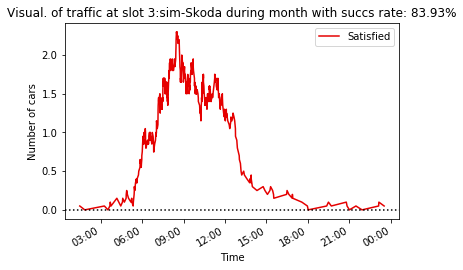

In [26]:
succes_rate = round((sim.slots[slot_id].vehicle_ctr/sim.slots[slot_id].total)*100, 2)
fig, ax = plt.subplots()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.title("Visual. of traffic at slot " + str(slot_id) + ":sim-" + sim.name + " during month with succs rate: " + str(succes_rate)+ "%")
plt.ylabel("Number of cars")
plt.xlabel("Time")

#plt.plot(new_times,new_ctrs, color='xkcd:blue', label='Demand')
plt.plot(times_ch, ctrs_ch, color='xkcd:red', label='Satisfied')

#plt.axhline(sim.slots[slot_id].capacity, color = 'xkcd:green', linestyle='dashed', label='Capacity')

plt.axhline(0, color = 'xkcd:black', linestyle='dotted')
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('sim_' + sim.name + '_slot_' + str(slot_id) + '.png', dpi = 300)
plt.show()

#### Single simulation at selected spot

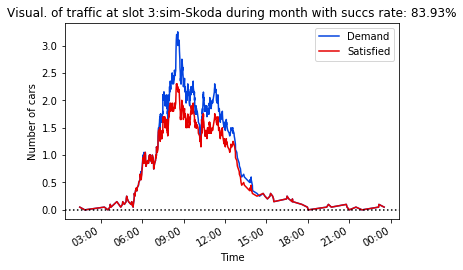

In [27]:
succes_rate = round((sim.slots[slot_id].vehicle_ctr/sim.slots[slot_id].total)*100, 2)
fig, ax = plt.subplots()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.title("Visual. of traffic at slot " + str(slot_id) + ":sim-" + sim.name + " during month with succs rate: " + str(succes_rate)+ "%")
plt.ylabel("Number of cars")
plt.xlabel("Time")

plt.plot(times,ctrs, color='xkcd:blue', label='Demand')
plt.plot(times_ch, ctrs_ch, color='xkcd:red', label='Satisfied')

#plt.axhline(sim.slots[slot_id].capacity, color = 'xkcd:green', linestyle='dashed', label='Capacity')

plt.axhline(0, color = 'xkcd:black', linestyle='dotted')
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('sim_' + sim.name + '_slot_' + str(slot_id) + '.png', dpi = 300)
plt.show()

#### Multiple simulations at selected spot

In [28]:
times, ctrs, times_ch1, ctrs_ch1 = visualize_prep(sim1, slot_id, False)
x, y, times_ch2, ctrs_ch2 = visualize_prep(sim2, slot_id, False)
x, y, times_ch3, ctrs_ch3 = visualize_prep(sim3, slot_id, False)


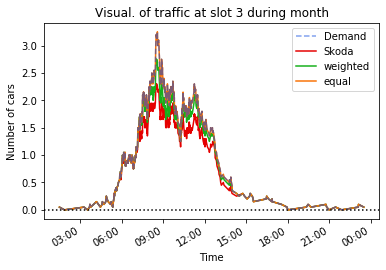

In [29]:
fig, ax = plt.subplots()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.title("Visual. of traffic at slot " + str(slot_id) + " during month")
plt.ylabel("Number of cars")
plt.xlabel("Time")

plt.plot(times,ctrs, color='xkcd:blue', label='Demand', linestyle='dashed', zorder = 3, alpha=0.5)
plt.plot(times_ch1, ctrs_ch1, color='xkcd:red', label=sim1.name)
plt.plot(times_ch2, ctrs_ch2, color='xkcd:green', label=sim2.name)
plt.plot(times_ch3, ctrs_ch3, color='xkcd:orange', label=sim3.name)

#plt.axhline(sim.slots[slot_id].capacity, color = 'xkcd:green', linestyle='dashed', label='Capacity')

plt.axhline(0, color = 'xkcd:black', linestyle='dotted')
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('all_sim_slot_' + str(slot_id) + '.png', dpi = 300)
plt.show()

#### Overall visualization

In [30]:
s1_t, s1_c, s1_t_ch, s1_c_ch = visualize_prep(sim1, None, False)
s2_t, s2_c, s2_t_ch, s2_c_ch = visualize_prep(sim2, None, False)
s3_t, s3_c, s3_t_ch, s3_c_ch = visualize_prep(sim3, None, False)
succes_rate1 = round((sim1.charged_cars/sim1.total_cars)*100, 2)
succes_rate2 = round((sim2.charged_cars/sim2.total_cars)*100, 2)
succes_rate3 = round((sim3.charged_cars/sim3.total_cars)*100, 2)

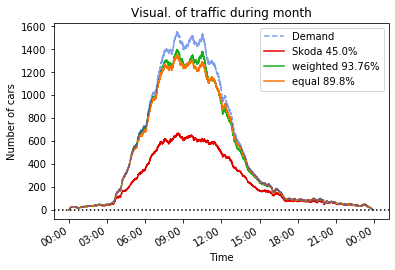

In [31]:
fig, ax = plt.subplots()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.title("Visual. of traffic during month")
plt.ylabel("Number of cars")
plt.xlabel("Time")

plt.plot(s1_t, s1_c, color='xkcd:blue', label='Demand', linestyle='dashed', zorder = 3, alpha=0.5)
plt.plot(s1_t_ch, s1_c_ch, color='xkcd:red', label=sim1.name + " " + str(succes_rate1) + "%")
plt.plot(s2_t_ch, s2_c_ch, color='xkcd:green', label=sim2.name + " " + str(succes_rate2) + "%")
plt.plot(s3_t_ch, s3_c_ch, color='xkcd:orange', label=sim3.name + " " + str(succes_rate3) + "%")

plt.axhline(0, color='xkcd:black', linestyle='dotted')
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('all_sims.png', dpi=300)
plt.show()

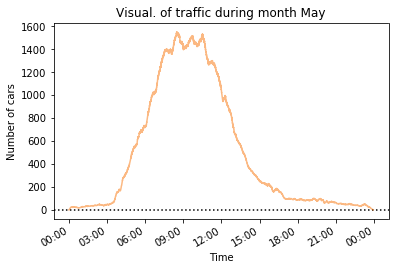

In [54]:
#TMP
#import subprocess; subprocess.check_call(["latex"]

fig, ax = plt.subplots()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.title("Visual. of traffic during month May")
plt.ylabel("Number of cars")
plt.xlabel("Time")

plt.plot(s1_t, s1_c, color='xkcd:orange', label='Demand', zorder = 3, alpha=0.5)
#plt.plot(s1_t_ch, s1_c_ch, color='xkcd:red', label=sim1.name + " " + str(succes_rate1) + "%")
#plt.plot(s2_t_ch, s2_c_ch, color='xkcd:green', label=sim2.name + " " + str(succes_rate2) + "%")
#plt.plot(s3_t_ch, s3_c_ch, color='xkcd:orange', label=sim3.name + " " + str(succes_rate3) + "%")

plt.axhline(0, color='xkcd:black', linestyle='dotted')
plt.gcf().autofmt_xdate()
#plt.legend()
plt.savefig('tmp_all_sims.png', dpi=300)
plt.show()


### Traffic during month

#### Daily summary

In [43]:

df = sim1.log
df = df.loc[df['arrival'].dt.date == df['departure'].dt.date]
df = df[(df['arrival'] > '2019-05-13 00:00:01') & (df['arrival'] < '2019-05-31 23:59:00')]
df1 = df.groupby(df['arrival'].dt.date).size().reset_index(name='Count')

dates = df1['arrival'].to_list()
occur = df1['Count'].to_list()

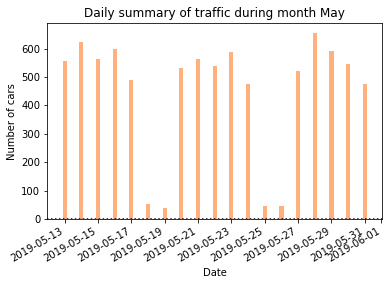

In [44]:
fig, ax = plt.subplots()
ax.xaxis_date()
plt.title("Daily summary of traffic during month May")
plt.ylabel("Number of cars")
plt.xlabel("Date")

plt.bar(dates, occur, color='xkcd:peach', width=0.25)

plt.axhline(0, color='xkcd:black', linestyle='dotted')
plt.gcf().autofmt_xdate()
plt.savefig('all_sims.png', dpi=300)
plt.show()



In [41]:
dates

[datetime.date(2019, 5, 13),
 datetime.date(2019, 5, 14),
 datetime.date(2019, 5, 15),
 datetime.date(2019, 5, 16),
 datetime.date(2019, 5, 17),
 datetime.date(2019, 5, 18),
 datetime.date(2019, 5, 19),
 datetime.date(2019, 5, 20),
 datetime.date(2019, 5, 21),
 datetime.date(2019, 5, 22),
 datetime.date(2019, 5, 23),
 datetime.date(2019, 5, 24),
 datetime.date(2019, 5, 25),
 datetime.date(2019, 5, 26),
 datetime.date(2019, 5, 27),
 datetime.date(2019, 5, 28),
 datetime.date(2019, 5, 29),
 datetime.date(2019, 5, 30)]

#### Whole month 

In [34]:
#If month is True then visualize for whole 31 days
times, ctrs, times_ch, ctrs_ch = visualize_prep(sim1, slot_id, True)

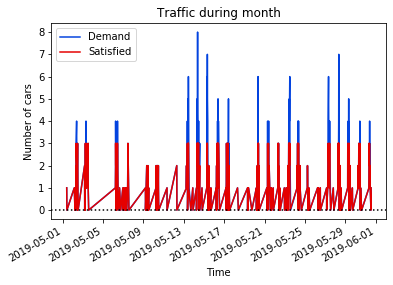

In [35]:

#STILL CONTINOUS!!!!!!

fig, ax = plt.subplots()
ax.xaxis_date()
#myFmt = mdates.DateFormatter('%H:%M')
#ax.xaxis.set_major_formatter(myFmt)
plt.title("Traffic during month")
plt.ylabel("Number of cars")
plt.xlabel("Time")

plt.plot(times,ctrs, color='xkcd:blue', label='Demand')
plt.plot(times_ch, ctrs_ch, color='xkcd:red', label='Satisfied')

#plt.axhline(sim.slots[slot_id].capacity, color = 'xkcd:green', linestyle='dashed', label='Capacity')

plt.axhline(0, color = 'xkcd:black', linestyle='dotted')
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('month.png', dpi=300)
plt.show()

## Simple optimization

In [ ]:
#We must establish values needed for satisfaction of all users
upper_max_cpct = []
for i in range(len(sim.slots)):
    times, ctrs, times_ch, ctrs_ch = visualize_prep(sim, i, True)
    upper_max_cpct.append(max(ctrs))


### Optimization focused on maximizing charged kWh

In [ ]:
#Now we decrement one charger from spot X each loop, spot X is the one that has the lowest decrease of electricity output without one charger
sim = sim1
opt_cpct = upper_max_cpct.copy()

limit = sum(default_cpct)

max_cpct = []
while sum(opt_cpct) != limit:
    #print(sum(opt_cpct))
    max = np.NINF
    for i in range(len(sim.slots)):
        if opt_cpct[i] > 0:
            tmp_cpct = opt_cpct.copy()
            tmp_cpct[i] = tmp_cpct[i] - 1
            tmp_slots = create_slots(tmp_cpct)
            tmp_sim = Simulation(traffic, tmp_slots, "opt")
            tmp_sim.simulate_slot(i)
            #print(str(i) + " --- " + str(tmp_sim.total_kW))

            if max < tmp_sim.total_kWh:
                max = tmp_sim.total_kWh
                #print("Found new max at: " + str(i))
                max_cpct = tmp_cpct.copy()

    opt_cpct = max_cpct.copy()

In [ ]:

#Optimal capacity to maximize kWh charged has been found, now we can try and simulate it
#          [9.0, 13.0, 16.0, 5.0, 9.0, 13.0, 6.0, 5.0, 13.0, 4.0, 1.0, 8.0, 12.0, 2.0, 2.0, 5.0, 7.0, 4.0]
#opt_cpct = [9.0, 13.0, 16.0, 5.0, 9.0, 13.0, 6.0, 5.0, 13.0, 4.0, 1.0, 8.0, 12.0, 2.0, 2.0, 5.0, 7.0, 4.0]
traffic = load_traffic("input/3_traffic_export_may.csv")
opt_cpct = find_optimal(None, traffic, default_cpct) #This function is identical to code above
slots4 = create_slots(opt_cpct)
sim4 = Simulation(traffic, slots4, "opt-kWh")
sim4.simulate()

### Heuristic focused on maximizing number of charged vehicles

In [ ]:
#Now we decrement one charger from spot X each loop, spot X is the one that has the lowest decrease of electricity output without one charger
sim = sim1
found_cpct = upper_max_cpct.copy()

limit = sum(default_cpct)

max_cpct = []
while sum(found_cpct) != limit:
    #print(sum(opt_cpct))
    max = np.NINF
    for i in range(len(sim.slots)):
        if found_cpct[i] > 0:
            tmp_cpct = found_cpct.copy()
            tmp_cpct[i] = tmp_cpct[i] - 1
            tmp_slots = create_slots(tmp_cpct)
            tmp_sim = Simulation(traffic, tmp_slots, "opt")
            tmp_sim.simulate_slot(i)
            #print(str(i) + " --- " + str(tmp_sim.total_kW))

            if max < tmp_sim.charged_cars:
                max = tmp_sim.charged_cars
                #print("Found new max at: " + str(i))
                max_cpct = tmp_cpct.copy()

    found_cpct = max_cpct.copy()

In [ ]:
#not optimal, only heuristic
#Heuristic capacity to maximize number of charged vehicles has been found, now we can try and simulate it
traffic = load_traffic("input/3_traffic_export_may.csv")

slots5 = create_slots(found_cpct)
sim5 = Simulation(traffic, slots5, "opt-cars")
sim5.simulate()
sum(opt_cpct)

### Comparison with previous solutions

In [ ]:
sims = [sim1, sim2, sim3, sim4, sim5]
names = []
ch_cars = []
total_cars = []
total_ch_time = []
total_kw = []
for sm in sims:
    names.append(sm.name)
    ch_cars.append(sm.charged_cars)
    total_ch_time.append(sm.total_ch_time)
    total_kw.append(sm.total_kWh)
    total_cars.append(sm.total_cars)
    

In [ ]:
res = {'name': names,
        'ch_cars': ch_cars,
        'total_cars': total_cars,
        'total_ch_time': total_ch_time,
        'total_energy_output': total_kw}
results = pd.DataFrame(res)
results['succes_rate'] = (results['ch_cars']/results['total_cars'])*100
#results['avg_slot_succes'] = [usage['satisfied_perc'].mean(), usage2['satisfied_perc'].mean(), usage3['satisfied_perc'].mean()]
results.head()

## Crossvalidation

In [ ]:
sets = get_sets("input/complete_traffic_export.csv") #divide data into 28 sets, each containing one random day of weekdays
tmp_sets = []
test = []
#cpct = [14, 1, 2, 3, 1, 1, 6, 1, 2 ,3, 3, 1, 1, 2, 2, 40, 24, 27] #original capacity from Skoda Auto
cpct = [4, 1, 2, 3, 1, 1, 6, 1, 2 ,3, 3, 1, 1, 2, 2, 40, 1, 16] #decreased capacity during call with Martin
train_kwh = []
train_time = []
test_kwh = []
test_time = []
train_sims = []

for i in range(0, 28, 4):
    test = []
    tmp_sets = sets.copy()
    for j in range(4):
        add = tmp_sets[i]
        test.extend(add)
        tmp_sets.remove(add)
    train = [item for sublist in tmp_sets for item in sublist]
    train = order_set(train)
    train = [item for sublist in train for item in sublist]

    test = order_set(test)
    test = [item for sublist in test for item in sublist]
    
    print("Length of train set: " + str(len(train)))
    print("Length of test set: " + str(len(test)))
    
    train_opt = find_optimal(None, train, cpct)
    test_opt = find_optimal(None, test, cpct)

    print("Sum of train capacity: " + str(train_opt))
    print("Sum of test capacity: " + str(test_opt))
    
    
    train_slots = create_slots(train_opt)
    sim_train = Simulation(test, train_slots, "trained setup on test data")
    sim_train.simulate()

    test_slots = create_slots(test_opt)
    sim_test = Simulation(test, test_slots, "overfitted setup on test data")
    sim_test.simulate()
    
    #Append to lists of results
    train_kwh.append(sim_train.total_kWh)
    train_time.append(sim_train.total_ch_time)
    test_kwh.append(sim_test.total_kWh)
    test_time.append(sim_test.total_ch_time)
    train_sims.append(sim_train)

    print("-----------")
        


In [ ]:
#sum(cpct)

In [ ]:
#Create Pandas DataFrame
results = {"Trained setup on test set [time]": train_time,
        'Overfitted setup [time]': test_time,
        'Trained setup on test set [kWh]': train_kwh,
        'Overfitted setup [kWh]': test_kwh
        }

df = pd.DataFrame(results, columns = ['Trained setup on test set [time]', 'Overfitted setup [time]', 'Trained setup on test set [kWh]', 'Overfitted setup [kWh]'])
df['Success rate [%]'] = (df['Trained setup on test set [kWh]']/df['Overfitted setup [kWh]'])*100
df


In [ ]:
#Results with highlighted maximum values
df.style.apply(highlight_max,subset=pd.IndexSlice[:, ['Success rate [%]']])




In [ ]:
#Performance of found setup on whole traffic data
#Low performance is because budget of charging stations has been decreased, now is 90 instead of original 134
#winning_cpct = [4.0, 8.0, 9.0, 4.0, 6.0, 9.0, 5.0, 4.0, 10.0, 4.0, 1.0, 5.0, 8.0, 1.0, 1.0, 3.0, 5.0, 3.0]
traffic = load_traffic("input/complete_traffic_export.csv") #traffic exported from SQL database
slots = create_slots(winning_cpct)
sim_win = Simulation(traffic, slots, "win")
sim_win.simulate()

In [ ]:
sum(winning_cpct)

## Different fleet scenarios

### Random N%

In [ ]:
#Randomly selects N percent of cars as electric during initiation
#use random.sample(list, number_of_samples)
N = 0.5 #50%

unique_cars = get_unique_cars("input/3_traffic_export_may.csv")
random_cars = random.sample(unique_cars, int(len(unique_cars)*N))

random_traffic = load_selected_traffic("input/3_traffic_export_may.csv", random_cars)
slots = create_slots(default_cpct)
sim_random = Simulation(random_traffic, slots, "random 50%")
sim_random.simulate()

In [ ]:
len(unique_cars)
x = np.array(unique_cars) 
print(len(np.unique(x))) 

### Based on stop length

In [ ]:
traffic = load_traffic("input/3_traffic_export_may.csv")
slots = create_slots(default_cpct)
sim_all = Simulation(traffic, slots, "Skoda")
sim_all.simulate()
sim_all.total_kWh

In [ ]:
df = sim_all.log
df['duration'] = df['departure'] - df['arrival']
df.groupby(['car_id']).sum()

In [ ]:
df['tmp'] = 1
df['duration_sec'] = df.duration.dt.total_seconds()
nw = df.groupby("car_id").sum()
nw = nw.reset_index()
nw['avg'] = nw['duration_sec']/nw['tmp']
nw = nw.sort_values(by=['avg'], ascending=False)
longest_stop_list = nw['car_id'].to_list()


In [ ]:
#stop_length_cpct = default_cpct
stop_length_cpct = [8.0, 11.0, 12.0, 6.0, 9.0, 12.0, 6.0, 6.0, 13.0, 6.0, 3.0, 8.0, 11.0, 3.0, 2.0, 6.0, 7.0, 5.0]
selected_cars = longest_stop_list[:int(len(longest_stop_list)*N)]
selected_traffic = load_selected_traffic("input/3_traffic_export_may.csv", selected_cars)
slots = create_slots(stop_length_cpct)
sim_stop_length = Simulation(selected_traffic, slots, "stop length 50%")
sim_stop_length.simulate()

In [ ]:
nw

## Experiments

Focused on performance of optimization in scenarios with decreased capacity of charging stations.<br>
Each experiment will be cross-validated on set of 28 random weekdays, this gives us 140 days.<br>
K-fold crossvalidate method is used, always having 4 sets of weekdays as testing dataset and 24 sets of weekdays as training dataset.<br> K-fold where k = 4 and n = 28. <br> In this case we have 7 different combinations.<br>
Dataset is randomly shuffled but each one of 28 sets contains one Monday, one Tuesday, etc.<br>
Around 85% satisfied cars could be considered as good performance.<br>
Traffic data from weekdays between March and September.


Experiments:
    1. Default capacity
    2. 80% of default capacity
    3. 65% of default capacity
    4. 50% of default capacity

In [ ]:
#Prepare dataset for crossvalidate
sets = get_sets("input/complete_traffic_export.csv")

### Default capacity

Default capacity with total of 134 available chargers.


In [ ]:
default_cpct = [134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print("Result log:")
train_sims, test_sims = crossvalidate_optimal(sets.copy(), default_cpct); #same code as in Crossvalidation section, function used to save space

#Get results
train_kwh = []
train_time = []
test_kwh = []
test_time = []
for i in range(len(train_sims)):
    train_kwh.append(train_sims[i].total_kWh)
    train_time.append(train_sims[i].total_ch_time)
    test_kwh.append(test_sims[i].total_kWh)
    test_time.append(test_sims[i].total_ch_time)


In [ ]:
dflt_results = {'Trained setup on test set [time]': train_time,
        'Overfitted setup [time]': test_time,
        'Trained setup on test set [kWh]': train_kwh,
        'Overfitted setup [kWh]': test_kwh
        }

dflt = pd.DataFrame(dflt_results, columns = ['Trained setup on test set [time]', 'Overfitted setup [time]', 'Trained setup on test set [kWh]', 'Overfitted setup [kWh]'])
dflt['Success rate [%]'] = (dflt['Trained setup on test set [kWh]']/dflt['Overfitted setup [kWh]'])*100
cmprs = dflt.tail(1).copy()
cmprs['name'] = 'dflt'
dflt.style.apply(highlight_max,subset=pd.IndexSlice[:, ['Success rate [%]']]).format({'Success rate [%]': "{:.2f}" , 'Trained setup on test set [kWh]' : "{:.4E}", 'Overfitted setup [kWh]' : "{:.4E}"})


Result log and Pandas DataFrame show us that there is a little difference between performance of overfitted setup and setup trained on training data. Ratio between trained and overfitted setup is calculated in column "Success rate". This means low risk of overfitting the data. <br><br>
To show performance of optimization we will decrement charging capacity in next steps, therefore more coherent setup will be needed to achieve high performance.

#### Comparison with equally distributed setup

In [ ]:

print("Equal results log:")
equal_sims = crossvalidate_equal(sets.copy(), default_cpct); 

#Get results
equal_kwh = []
equal_time = []

for i in range(len(equal_sims)):
    equal_kwh.append(equal_sims[i].total_kWh)
    equal_time.append(equal_sims[i].total_ch_time)


In [ ]:
equal_dflt_res = {'Equal setup on test set [time]': equal_time,
        'Trained setup on test set [time]': train_time,
        'Equal setup on test set [kWh]': equal_kwh,
        'Trained setup on test set [kWh]': train_kwh,
        }
equal_dflt = pd.DataFrame(equal_dflt_res, columns = ['Equal setup on test set [time]', 'Trained setup on test set [time]', 'Equal setup on test set [kWh]', 'Trained setup on test set [kWh]'])
equal_dflt['Success rate [%]'] = (equal_dflt['Equal setup on test set [kWh]']/equal_dflt['Trained setup on test set [kWh]'])*100
equal_dflt.style.format({'Success rate [%]': "{:.2f}", 'Equal setup on test set [kWh]' : "{:.4E}", 'Trained setup on test set [kWh]' : "{:.4E}"})

### 80% of default capacity

Approximately 80% of default capacity => 134*0.8 = 107.2

In [ ]:
cpct_80 = [107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print("Result log:")
_80_train_sims, _80_test_sims = crossvalidate_optimal(sets.copy(), cpct_80); #same code as in Crossvalidation section, function used to save space

#Get results
_80_train_kwh = []
_80_train_time = []
_80_test_kwh = []
_80_test_time = []
for i in range(len(_80_train_sims)):
    _80_train_kwh.append(_80_train_sims[i].total_kWh)
    _80_train_time.append(_80_train_sims[i].total_ch_time)
    _80_test_kwh.append(_80_test_sims[i].total_kWh)
    _80_test_time.append(_80_test_sims[i].total_ch_time)


In [ ]:
_80_results = {"Trained setup on test set [time]": _80_train_time,
        'Overfitted setup [time]': _80_test_time,
        'Trained setup on test set [kWh]': _80_train_kwh,
        'Overfitted setup [kWh]': _80_test_kwh
        }

cpct_80 = pd.DataFrame(_80_results, columns = ['Trained setup on test set [time]', 'Overfitted setup [time]', 'Trained setup on test set [kWh]', 'Overfitted setup [kWh]'])
cpct_80['Success rate [%]'] = (cpct_80['Trained setup on test set [kWh]']/cpct_80['Overfitted setup [kWh]'])*100

_tmp = cpct_80.tail(1).copy()
_tmp['name'] = 'cpct_80'
cmprs = cmprs.append(_tmp)
cpct_80.style.apply(highlight_max,subset=pd.IndexSlice[:, ['Success rate [%]']]).format({'Success rate [%]': "{:.2f}" , 'Trained setup on test set [kWh]' : "{:.4E}", 'Overfitted setup [kWh]' : "{:.4E}"})


With 80% of original capacity the performance is still good, around 90% of successfully charged cars. Comparison with exact kWh will follow after experiments.

#### Comparison with equally distributed setup

In [ ]:

print("Equal results log:")
_80_equal_sims = crossvalidate_equal(sets.copy(), cpct_80); 

#Get results
_80_equal_kwh = []
_80_equal_time = []

for i in range(len(_80_equal_sims)):
    _80_equal_kwh.append(_80_equal_sims[i].total_kWh)
    _80_equal_time.append(_80_equal_sims[i].total_ch_time)


In [ ]:
equal_80_res = {'Equal setup on test set [time]': _80_equal_time,
        'Trained setup on test set [time]': _80_train_time,
        'Equal setup on test set [kWh]': _80_equal_kwh,
        'Trained setup on test set [kWh]': _80_train_kwh,
        }
equal_80 = pd.DataFrame(equal_80_res, columns = ['Equal setup on test set [time]', 'Trained setup on test set [time]', 'Equal setup on test set [kWh]', 'Trained setup on test set [kWh]'])
equal_80['Success rate [%]'] = (equal_80['Equal setup on test set [kWh]']/equal_80['Trained setup on test set [kWh]'])*100
equal_80.style.format({'Success rate [%]': "{:.2f}", 'Equal setup on test set [kWh]' : "{:.4E}", 'Trained setup on test set [kWh]' : "{:.4E}"})

### 65% of default capacity

Approximately 65% of default capacity => 134*0.7 = 87.1

In [ ]:
cpct_65 = [87, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print("Result log:")
_65_train_sims, _65_test_sims = crossvalidate_optimal(sets.copy(), cpct_65); #same code as in Crossvalidation section, function used to save space

#Get results
_65_train_kwh = []
_65_train_time = []
_65_test_kwh = []
_65_test_time = []
for i in range(len(_65_train_sims)):
    _65_train_kwh.append(_65_train_sims[i].total_kWh)
    _65_train_time.append(_65_train_sims[i].total_ch_time)
    _65_test_kwh.append(_65_test_sims[i].total_kWh)
    _65_test_time.append(_65_test_sims[i].total_ch_time)


In [ ]:
_65_results = {"Trained setup on test set [time]": _65_train_time,
        'Overfitted setup [time]': _65_test_time,
        'Trained setup on test set [kWh]': _65_train_kwh,
        'Overfitted setup [kWh]': _65_test_kwh
        }

cpct_65 = pd.DataFrame(_65_results, columns = ['Trained setup on test set [time]', 'Overfitted setup [time]', 'Trained setup on test set [kWh]', 'Overfitted setup [kWh]'])
cpct_65['Success rate [%]'] = (cpct_65['Trained setup on test set [kWh]']/cpct_65['Overfitted setup [kWh]'])*100

_tmp = cpct_65.tail(1).copy()
_tmp['name'] = 'cpct_65'
cmprs = cmprs.append(_tmp)
cpct_65.style.apply(highlight_max,subset=pd.IndexSlice[:, ['Success rate [%]']]).format({'Success rate [%]': "{:.2f}" , 'Trained setup on test set [kWh]' : "{:.4E}", 'Overfitted setup [kWh]' : "{:.4E}"})


Even with 65% of original capacity there is still solid performance. From crossvalidate results we can see that there is a little difference between performance of overfitted setup and trained setup. This tells us that we have prepared training/testing dataset with almost perfectly balanced traffic. 

#### Comparison with equally distributed setup

In [ ]:

print("Equal results log:")
_65_equal_sims = crossvalidate_equal(sets.copy(), cpct_65); 

#Get results
_65_equal_kwh = []
_65_equal_time = []

for i in range(len(_65_equal_sims)):
    _65_equal_kwh.append(_65_equal_sims[i].total_kWh)
    _65_equal_time.append(_65_equal_sims[i].total_ch_time)


In [ ]:
equal_65_res = {'Equal setup on test set [time]': _65_equal_time,
        'Trained setup on test set [time]': _65_train_time,
        'Equal setup on test set [kWh]': _65_equal_kwh,
        'Trained setup on test set [kWh]': _65_train_kwh,
        }
equal_65 = pd.DataFrame(equal_65_res, columns = ['Equal setup on test set [time]', 'Trained setup on test set [time]', 'Equal setup on test set [kWh]', 'Trained setup on test set [kWh]'])
equal_65['Success rate [%]'] = (equal_65['Equal setup on test set [kWh]']/equal_65['Trained setup on test set [kWh]'])*100
equal_65.style.format({'Success rate [%]': "{:.2f}", 'Equal setup on test set [kWh]' : "{:.4E}", 'Trained setup on test set [kWh]' : "{:.4E}"})

### 50% of default capacity

Approximately 50% of default capacity => 134*0.5 = 67

In [ ]:
cpct_50 = [67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print("Result log:")
_50_train_sims, _50_test_sims = crossvalidate_optimal(sets.copy(), cpct_50); #same code as in Crossvalidation section, function used to save space

#Get results
_50_train_kwh = []
_50_train_time = []
_50_test_kwh = []
_50_test_time = []
for i in range(len(_50_train_sims)):
    _50_train_kwh.append(_50_train_sims[i].total_kWh)
    _50_train_time.append(_50_train_sims[i].total_ch_time)
    _50_test_kwh.append(_50_test_sims[i].total_kWh)
    _50_test_time.append(_50_test_sims[i].total_ch_time)


In [ ]:
_50_results = {"Trained setup on test set [time]": _50_train_time,
        'Overfitted setup [time]': _50_test_time,
        'Trained setup on test set [kWh]': _50_train_kwh,
        'Overfitted setup [kWh]': _50_test_kwh
        }

cpct_50 = pd.DataFrame(_50_results, columns = ['Trained setup on test set [time]', 'Overfitted setup [time]', 'Trained setup on test set [kWh]', 'Overfitted setup [kWh]'])
cpct_50['Success rate [%]'] = (cpct_50['Trained setup on test set [kWh]']/cpct_50['Overfitted setup [kWh]'])*100

_tmp = cpct_50.tail(1).copy()
_tmp['name'] = 'cpct_50'
cmprs = cmprs.append(_tmp)
cpct_50.style.apply(highlight_max,subset=pd.IndexSlice[:, ['Success rate [%]']]).format({'Success rate [%]': "{:.2f}" , 'Trained setup on test set [kWh]' : "{:.4E}", 'Overfitted setup [kWh]' : "{:.4E}"})


With 50% of original capacity we can still see good performance in Result log. Each simulation having around 75% of successfully charged vehicles. Difference between overfitted and trained data has become more significant but is still only in 1-2 percents.

#### Comparison with equally distributed setup

In [ ]:

print("Equal results log:")
_50_equal_sims = crossvalidate_equal(sets.copy(), cpct_50); 

#Get results
_50_equal_kwh = []
_50_equal_time = []

for i in range(len(_50_equal_sims)):
    _50_equal_kwh.append(_50_equal_sims[i].total_kWh)
    _50_equal_time.append(_50_equal_sims[i].total_ch_time)


In [ ]:
equal_50_res = {'Equal setup on test set [time]': _50_equal_time,
        'Trained setup on test set [time]': _50_train_time,
        'Equal setup on test set [kWh]': _50_equal_kwh,
        'Trained setup on test set [kWh]': _50_train_kwh,
        }
equal_50 = pd.DataFrame(equal_50_res, columns = ['Equal setup on test set [time]', 'Trained setup on test set [time]', 'Equal setup on test set [kWh]', 'Trained setup on test set [kWh]'])
equal_50['Success rate [%]'] = (equal_50['Equal setup on test set [kWh]']/equal_50['Trained setup on test set [kWh]'])*100
equal_50.style.format({'Success rate [%]': "{:.2f}", 'Equal setup on test set [kWh]' : "{:.4E}", 'Trained setup on test set [kWh]' : "{:.4E}"})


In [ ]:
pd.reset_option('display.float_format')
print(equal_50.to_latex())

### Comparison of different capacities

Because all experiments were done on same dataset we can now compare their kWh output. We will compare row with ID-6 from all four DataFrames. In column 'Perc of max output' we count how big part of output from default setup can be achieved using only N% of its original capacity. This maximal output is considered maximal possible output that can be achieved.

In [ ]:
_max = float(cmprs.head(1)['Trained setup on test set [kWh]'])
cmprs['Perc of max output'] = (cmprs['Trained setup on test set [kWh]']/_max)*100
cmprs

From DataFrame above is clearly visible that there is not direct proportionality between number of chargers and number of successfully charged cars. Even with half of original capacity we can still achieve solid number of charged vehicles - 78%. 

# THE END - bellow is only code for debuging purposes

## Multiple months simulation

In [ ]:

default_cpct = [14, 1, 2, 3, 1, 1, 6, 1, 2 ,3, 3, 1, 1, 2, 2, 40, 24, 27] #capacity
#default_cpct = [i * 2 for i in default_cpct]
traffic = []
files = sorted(glob.glob("input/*_traffic_export_*.csv"))
for file in files:
    traffic.extend(load_traffic(file))

traffic


In [ ]:
slots = create_slots(default_cpct)
sim_all = Simulation(traffic, slots, "Skoda")
sim_all.simulate()
sim_all.total_kWh

In [ ]:
log = sim_all.log
log['weekday'] = log.arrival.dt.dayofweek
log

In [ ]:
log.loc[log['arrival'].dt.date == log['departure'].dt.date]

In [ ]:
slt = sim_all.slots[2].tmp_log
slt

## Debug 

In [ ]:
dt.datetime.today().weekday()

In [ ]:
d = sim1.log

d['day'] = d['arrival'].dt.date

x = dt.date(2019, 9, 14)
d.loc[d['day'] == x]


In [ ]:
traffic = load_traffic("input/complete_traffic_export.csv")
slots = create_slots(default_cpct)
sim_all = Simulation(traffic, slots, "Skoda")
sim_all.simulate()
sim_all.total_kWh

In [ ]:
df = sim_all.log
df

In [ ]:
df['duration'] = df['departure'] - df['arrival']
df.groupby(['car_id']).sum()

In [ ]:
df['tmp'] = 1
df['duration_sec'] = df.duration.dt.total_seconds()
nw = df.groupby("car_id").sum()
nw = nw.reset_index()

In [ ]:
nw

In [ ]:
nw.loc[nw['car_id'] == 570936]

In [ ]:
nw['avg'] = nw['duration_sec']/nw['tmp']
nw

In [ ]:
nw = nw.sort_values(by=['avg'], ascending=False)
lst = nw['car_id'].to_list()
lst[]

In [ ]:
nw

In [ ]:
#ref time = 2,5 minute, manage to speed it up to 0,5 minute
# res = [9.0, 13.0, 16.0, 5.0, 9.0, 13.0, 6.0, 5.0, 13.0, 4.0, 1.0, 8.0, 12.0, 2.0, 2.0, 5.0, 7.0, 4.0]
default_cpct = [14, 1, 2, 3, 1, 1, 6, 1, 2, 3, 3, 1, 1, 2, 2, 40, 24, 27]
traffic = load_traffic("input/3_traffic_export_may.csv")
optml = find_optimal(None, traffic, default_cpct)

In [ ]:
print(optml)
optml == [9.0, 13.0, 16.0, 5.0, 9.0, 13.0, 6.0, 5.0, 13.0, 4.0, 1.0, 8.0, 12.0, 2.0, 2.0, 5.0, 7.0, 4.0]

In [ ]:
times, ctrs, times_ch, ctrs_ch = visualize_prep(sim1, 7, True)


In [ ]:
new_times = []
new_ctrs = []
for i in range(len(times)):
    var1 = times[i]
    if (i+1) == len(times):
        var2 = var1
    else:
        var2 = times[i+1]
    new_times.append(var1)
    new_times.append(var2)
    new_ctrs.append(ctrs[i])
    new_ctrs.append(ctrs[i])

In [ ]:
lmt = 5.0
# total kWh = 2434.8108333333334
# timne = datetime.timedelta(days=5, seconds=83607)
t = timedelta(0, 0)
for i in range(0, len(new_times) - 2, 2):
    #if new_times[i] == new_times[i+1]:
     #   print(str(new_times[i]) + " ---- " + str(new_times[i+1]))
      #  print(len(new_times))
    if new_ctrs[i] <= lmt and new_ctrs[i] > 0:
        print(str(new_times[i]) + " ---- " + str(new_times[i+1]))
        t += (new_times[i+1] - new_times[i])
    

In [ ]:
t

In [ ]:
new_times

In [ ]:
new_ctrs

In [ ]:
sim1.slots[7].char_time

In [ ]:
np.array(year_setups)
values = np.array([[11., 13., 13.,  5.,  9., 13.,  5.,  7., 11.,  5.,  1.,  7.,  9.,
         2.,  3.,  7.,  8.,  5.],
       [ 7., 15., 13.,  6., 11., 12.,  4.,  6., 12.,  5.,  1.,  8., 11.,
         3.,  1.,  6.,  8.,  5.],
       [ 9., 13., 16.,  5.,  9., 13.,  6.,  5., 13.,  4.,  1.,  8., 12.,
         2.,  2.,  5.,  7.,  4.],
       [ 6., 15., 17.,  4.,  9., 12.,  7.,  7., 13.,  4.,  1.,  6., 10.,
         2.,  3.,  6.,  8.,  4.],
       [ 9., 14., 14.,  5.,  9., 12.,  5.,  7., 12.,  5.,  1.,  7., 12.,
         2.,  1.,  6.,  8.,  5.],
       [ 9., 13., 14.,  6.,  9., 11.,  8.,  7., 11.,  5.,  2.,  8., 11.,
         3.,  1.,  7.,  5.,  4.],
       [11., 11., 14.,  5., 10., 12.,  7.,  6., 12.,  4.,  2.,  9., 11.,
         2.,  1.,  7.,  5.,  5.]])

In [ ]:
year_setups[4]

In [ ]:
cross_kWh['res_march']

In [ ]:
cross_kWh.append(pd.DataFrame(['may', 1,1,1,2,3,4,5], columns=['Optimised for month','res_march', 'res_april', 'res_may', 'res_june', 'res_july', 'res_august', 'res_september']))

In [ ]:
df = pd.DataFrame(columns=list('AB'))
df

In [ ]:
ctrs

In [ ]:
cp = [9.0, 13.0, 16.0, 5.0, 9.0, 13.0, 6.0, 5.0, 13.0, 4.0, 1.0, 8.0, 12.0, 2.0, 2.0, 5.0, 7.0, 4.0]
slots5 = create_slots(cp)
sim5 = Simulation(traffic, slots5, "opt")
sim5.simulate()
sum(cp)

In [ ]:
cpp = [8.0, 15.0, 12.0, 5.0, 10.0, 13.0, 7.0, 5.0, 14.0, 5.0, 2.0, 7.0, 13.0, 2.0, 2.0, 4.0, 6.0, 4.0]
slots6 = create_slots(cpp)
sim6 = Simulation(traffic, slots6, "opt")
sim6.simulate()
sum(cpp)

In [ ]:
new['car_id'].count()
new.loc[new['satisfied'] == True]['car_id'].count()



In [ ]:
new['car_id'].count()

In [ ]:
equal_setup = [8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
len(equal_setup)

In [ ]:
len(sim3.slots)

In [ ]:
import datetime
import random
import matplotlib.pyplot as plt

# make up some data
x = [datetime.time(1,1,1) + datetime.timedelta(hours=i) for i in range(12)]
y = [i+random.gauss(0,1) for i,_ in enumerate(x)]

# plot
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.plot(x,y)
# beautify the x-labels
plt.gcf().autofmt_xdate()


plt.show()

In [ ]:
times

In [ ]:
import datetime as dt
mytime = dt.datetime.strptime('0130','%H%M').time()
mydatetime = dt.datetime.combine(dt.date.today(), mytime)

In [ ]:
mytime

In [ ]:
dtf = sim2.slots[1].log

In [ ]:
dtf['same'] = dtf['arrival'].dt.date == dtf['departure'].dt.date
dtf = dtf.loc[dtf['arrival'].dt.date == dtf['departure'].dt.date]

In [ ]:
dtf.groupby('same').count()

In [ ]:
import numpy as np
from pylab import *
x=linspace(0,1,100)    
y=zeros(100)
y[x<0.5] = x[x<0.5]
y[x>=0.5] = 1 + x[x>=0.5]

pos = np.where(np.abs(np.diff(y)) >= 0.5)[0]

x[pos] = np.nan
y[pos] = np.nan

plot(x, y, '-')

In [ ]:
# library
import matplotlib.pyplot as plt
 
# Make fake dataset
height = [3, 12, 5, 18, 45]
bars = ('A', 'B', 'C', 'D', 'E')
# Choose the width of each bar and their positions
width = [0.1,0.2,3,1.5,0.3]
y_pos = [0,0.3,2,4.5,5.5]
 
# Make the plot
plt.bar(y_pos, height, width=width)
plt.xticks(y_pos, bars)
plt.show()
